In [27]:
import torch
import numpy as np

# # check if CUDA is available
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

#  rotation, translation,
# flipping and zooming
# convert data to a normalized torch.FloatTensor 
train_transforms = transforms.Compose([
#                                        transforms.ColorJitter(hue=.50, saturation=.50),
#                                        transforms.RandomRotation(0.3),
#                                        transforms.RandomPerspective(0.3),
#                                        transforms.RandomResizedCrop((224,224)),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.RandomVerticalFlip(),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                                        transforms.RandomErasing()
])

transforms = transforms.Compose([transforms.Resize((100,100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    
# choose the training and test datasets
train_data = datasets.ImageFolder('../input/my-cats-dogs-dataset-sorted/train/train', transform=train_transforms)
# test_data = TestDataset(data_dir + '/test', transform=transform)

In [39]:
train_data

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: ../input/my-cats-dogs-dataset-sorted/train/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [40]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [41]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [42]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#     num_workers=num_workers)

# specify the image classes
classes = train_data.classes; train_data.classes

['cat', 'dog']

### Visualize a Batch of Training Data

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [44]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

In [45]:
len(train_data.classes)

2

In [46]:
images.shape

(64, 3, 224, 224)

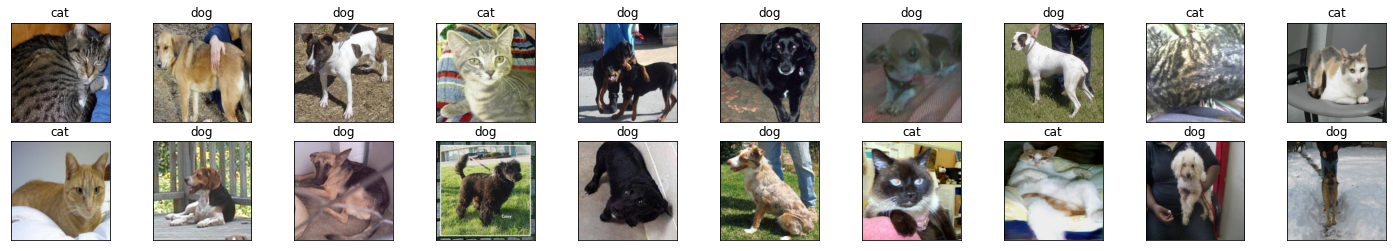

In [47]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 10 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [55]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [56]:
import torch.nn as nn
import torch.nn.functional as F

model = models.resnet152(pretrained=True)

In [57]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [59]:
from torch import optim

model.fc = nn.Sequential(nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Linear(512, 1),
                         nn.Sigmoid())

criterion = nn.BCELoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

In [65]:
# Check that we turned autograd on dense layers
# for param in model.parameters():
#     print(param.requires_grad)

---
## Train the Network

In [61]:
accuracy = []
model.eval()
with torch.no_grad():
    for data, target in valid_loader:
        data, target = data.to(device), target.float().view(-1,1).to(device)
        output = model(data)
        preds = (output > 0.5).float()
        accuracy_part = (preds == target).float()
        accuracy.extend(accuracy_part)
accuracy_ = torch.mean(torch.tensor(accuracy))
print(f'Val Accuracy Overall: {accuracy_}')

Val Accuracy Overall: 0.5242000222206116


In [63]:
model.load_state_dict(torch.load('/kaggle/working/model_cats_dogs.pt'))

<All keys matched successfully>

In [64]:
accuracy = []
model.eval()
with torch.no_grad():
    for data, target in valid_loader:
        data, target = data.to(device), target.float().view(-1,1).to(device)
        output = model(data)
        preds = (output > 0.5).float()
        accuracy_part = (preds == target).float()
        accuracy.extend(accuracy_part)
accuracy_ = torch.mean(torch.tensor(accuracy))
print(f'Val Accuracy Overall: {accuracy_}')

Val Accuracy Overall: 0.9883999824523926


In [62]:
# # number of epochs to train the model
# n_epochs = 80 # you may increase this number to train a final model
# valid_loss_min = np.Inf # track change in validation loss

# for epoch in range(1, n_epochs+1):

#     # keep track of training and validation loss
#     train_loss = 0.0
#     valid_loss = 0.0
    
#     ###################
#     # train the model #
#     ###################
#     model.train()
#     for data, target in train_loader:
#         data, target = data.to(device), target.float().view(-1,1).to(device)
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the batch loss
#         loss = criterion(output, target)
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()
#         # update training loss
#         train_loss += loss.item()*data.size(0)
        
#     ######################    
#     # validate the model #
#     ######################
#     model.eval()
#     with torch.no_grad():
#         for data, target in valid_loader:
#             # move tensors to GPU if CUDA is available
#             data, target = data.to(device), target.float().view(-1,1).to(device)
#             # forward pass: compute predicted outputs by passing inputs to the model
#             output = model(data)
#             # calculate the batch loss
#             loss = criterion(output, target)
#             # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
    
#     # calculate average losses
#     train_loss = train_loss/len(train_loader.dataset)
#     valid_loss = valid_loss/len(valid_loader.dataset)
        
#     # print training/validation statistics 
#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#         epoch, train_loss, valid_loss))
    
#     # save model if validation loss has decreased
#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss))
#         torch.save(model.state_dict(), '/kaggle/working/model_cats_dogs.pt')
#         valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.102537 	Validation Loss: 0.014605
Validation loss decreased (inf --> 0.014605).  Saving model ...
Epoch: 2 	Training Loss: 0.038765 	Validation Loss: 0.008519
Validation loss decreased (0.014605 --> 0.008519).  Saving model ...
Epoch: 3 	Training Loss: 0.035126 	Validation Loss: 0.005880
Validation loss decreased (0.008519 --> 0.005880).  Saving model ...
Epoch: 4 	Training Loss: 0.029161 	Validation Loss: 0.008768
Epoch: 5 	Training Loss: 0.025589 	Validation Loss: 0.008071
Epoch: 6 	Training Loss: 0.031326 	Validation Loss: 0.006666
Epoch: 7 	Training Loss: 0.027100 	Validation Loss: 0.005834
Validation loss decreased (0.005880 --> 0.005834).  Saving model ...
Epoch: 8 	Training Loss: 0.028615 	Validation Loss: 0.005668
Validation loss decreased (0.005834 --> 0.005668).  Saving model ...
Epoch: 9 	Training Loss: 0.026888 	Validation Loss: 0.007669
Epoch: 10 	Training Loss: 0.027328 	Validation Loss: 0.006254
Epoch: 11 	Training Loss: 0.024935 	Validation Lo

KeyboardInterrupt: 